# Import libraries

In [92]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import datasketch
from tqdm import tqdm

import nltk

In [93]:
print(os.getcwd())
path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print(path)
data_train = pd.read_csv(path + '/train.csv')


/Users/yusuke_sugihara/DA_Project1/DataAnalytics/Quora-question-pair-similarity
/Users/yusuke_sugihara/DA_Project1/DataAnalytics/data


# Preprocessing and Exploratory Data Analysis(Simple ver.)

In [94]:
print(data_train.shape)
print(data_train.head())

(404290, 6)
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [95]:
print(data_train.sample(10, random_state=10))

            id    qid1    qid2  \
108281  108281  177958  177959   
365075  365075  165259  495170   
399424  399424  110838  408590   
116651  116651  189968  189969   
251097  251097    6403   53276   
220896  220896  310761   60581   
236047  236047  346878  346879   
321985  321985  299182    3976   
377916  377916   76930   84506   
387985  387985  304668  175705   

                                                question1  \
108281  How can I get more information on cryptocurrency?   
365075  How much does each miner in Gold Rush: Alaska ...   
399424  Can a stock exchange be listed in another stoc...   
116651  What is the top speed of the quickest football...   
251097       Is there any way of knowing if a guy is gay?   
220896         Which is the best laptop to buy under 22k?   
236047  Can I press charges against someone who keeps ...   
321985  Which are the famous tourist places in Chhatti...   
377916  Is there a difference between native mini disp...   
387985  How can

In [96]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [97]:
# Check for null values in question 1
data_train[~data_train['question1'].apply(lambda question: type(question) == str)]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [98]:
# Check for null values in question 2
data_train[~data_train['question2'].apply(lambda question: type(question) == str)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [99]:
data_train = data_train.dropna(how="any").reset_index(drop=True)
data_train.shape

(404287, 6)

In [100]:
data_train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

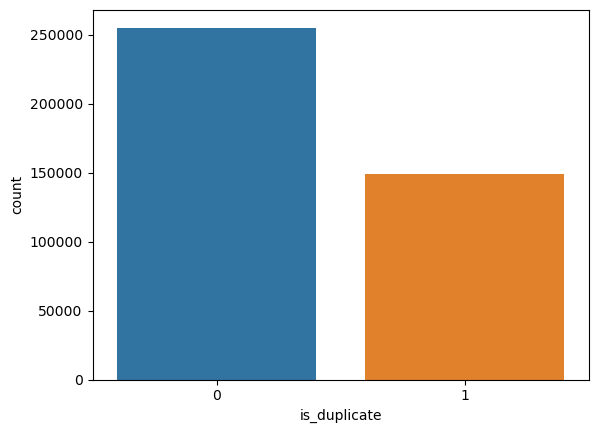

In [101]:
sns.countplot(data_train['is_duplicate'])

In [102]:
token_len_q1 = data_train['question1'].apply(lambda question: len(set(question)))
token_len_q2 = data_train['question2'].apply(lambda question: len(set(question)))

/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Token Length Distribution - Question 2')

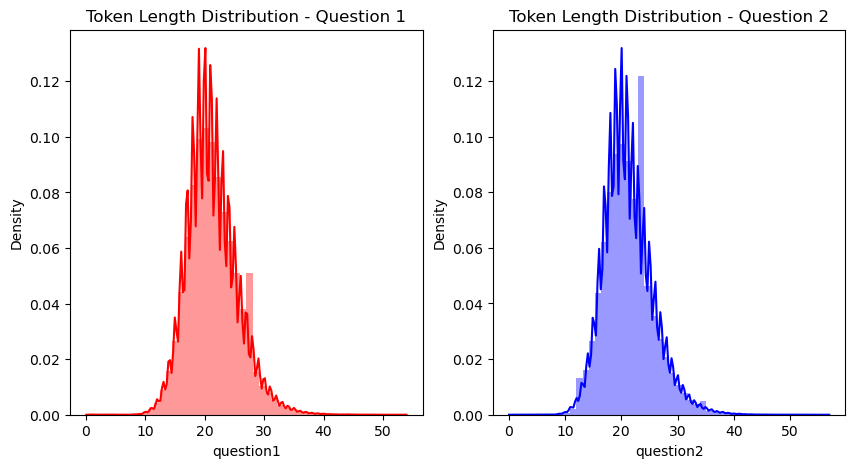

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(token_len_q1, ax=axs[0], color='red')
sns.distplot(token_len_q2, ax=axs[1], color='blue')
axs[0].set_title('Token Length Distribution - Question 1')
axs[1].set_title('Token Length Distribution - Question 2')

/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='question2'>

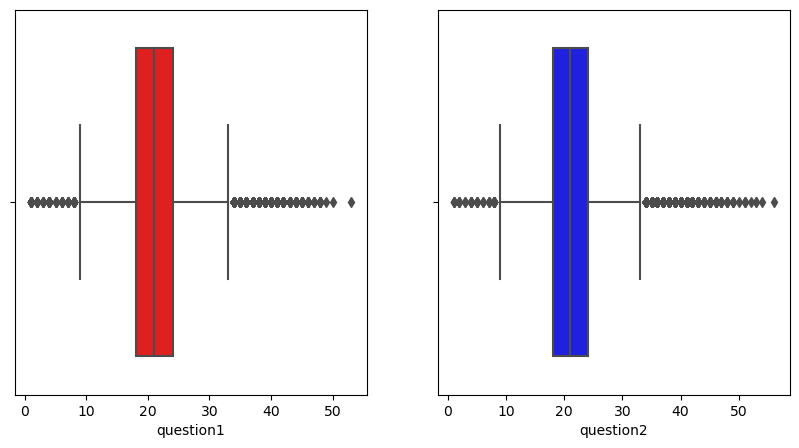

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(token_len_q1, ax=axs[0], color='red')
sns.boxplot(token_len_q2, ax=axs[1], color='blue')

In [105]:
sents_pairs = pd.concat([data_train[data_train['is_duplicate'] == 0].sample(100, random_state=10), 
                   data_train[data_train['is_duplicate'] == 1].sample(100, random_state=42)]).reset_index(drop=True).sample(frac=1.)
sents_pairs.shape

(200, 6)

In [106]:
sents = pd.concat([sents_pairs['question1'], sents_pairs['question2']])
sents.head()

115             Will you marry a girl who is not virgin?
32     I have forgotten my Facebook password and emai...
145    What are the reasons behind nuclear energy bei...
55     What do if I forget my user id and password of...
73     What are the disdvantages of democratic govern...
dtype: object

In [90]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Set Representation